# 4. Model Calibration - Credit Default

**Goal:** Ensure predicted probabilities reflect true probabilities of default.

**Why it Matters:** If a model predicts 70% default probability, we expect ~70% of those customers to actually default.

**Dataset:** UCI Credit Card Default

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import brier_score_loss, log_loss

# Load Credit Default Data
df = pd.read_excel('../data/raw/credit_card_default.xls', header=1)
df.rename(columns={'default payment next month': 'target'}, inplace=True)

X = df.drop(['ID', 'target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Data loaded: {X_train.shape[0]} training samples, {X_test.shape[0]} test samples")

Data loaded: 24000 training samples, 6000 test samples


## 1. Train Two Models: Random Forest vs Logistic Regression

Random Forests are known to produce poorly calibrated probabilities.

In [2]:
# Random Forest (typically uncalibrated)
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_proba = rf.predict_proba(X_test)[:, 1]

# Logistic Regression (typically well-calibrated)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])
lr.fit(X_train, y_train)
lr_proba = lr.predict_proba(X_test)[:, 1]

print("Models trained successfully.")

Models trained successfully.


## 2. Calibration Curves (Reliability Diagrams)

Compare predicted vs actual probabilities.

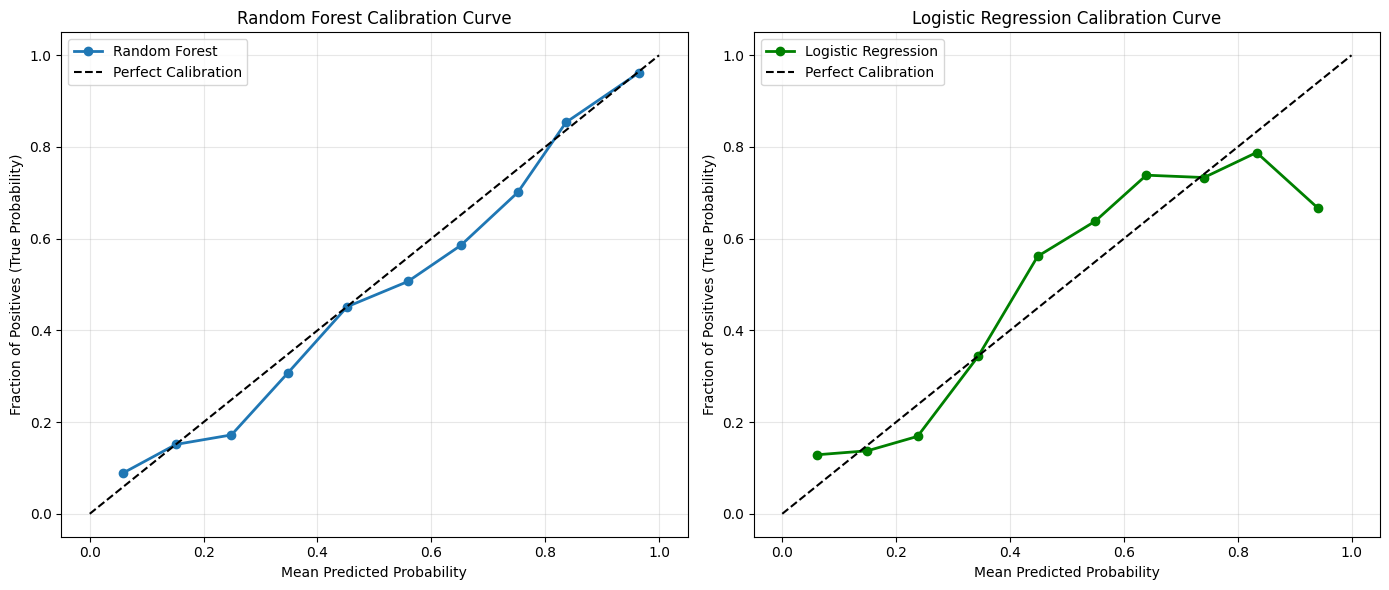


💡 Interpretation: Points closer to the diagonal indicate better calibration.


In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest Calibration
prob_true_rf, prob_pred_rf = calibration_curve(y_test, rf_proba, n_bins=10, strategy='uniform')
axes[0].plot(prob_pred_rf, prob_true_rf, marker='o', linewidth=2, label='Random Forest')
axes[0].plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
axes[0].set_xlabel('Mean Predicted Probability')
axes[0].set_ylabel('Fraction of Positives (True Probability)')
axes[0].set_title('Random Forest Calibration Curve')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Logistic Regression Calibration
prob_true_lr, prob_pred_lr = calibration_curve(y_test, lr_proba, n_bins=10, strategy='uniform')
axes[1].plot(prob_pred_lr, prob_true_lr, marker='o', linewidth=2, label='Logistic Regression', color='green')
axes[1].plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
axes[1].set_xlabel('Mean Predicted Probability')
axes[1].set_ylabel('Fraction of Positives (True Probability)')
axes[1].set_title('Logistic Regression Calibration Curve')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Interpretation: Points closer to the diagonal indicate better calibration.")

## 3. Calibration Metrics

Quantitative measures of calibration quality.

In [4]:
# Brier Score (lower is better)
rf_brier = brier_score_loss(y_test, rf_proba)
lr_brier = brier_score_loss(y_test, lr_proba)

# Log Loss (lower is better)
rf_logloss = log_loss(y_test, rf_proba)
lr_logloss = log_loss(y_test, lr_proba)

print("Calibration Metrics:")
print(f"\nRandom Forest:")
print(f"  Brier Score: {rf_brier:.4f}")
print(f"  Log Loss: {rf_logloss:.4f}")

print(f"\nLogistic Regression:")
print(f"  Brier Score: {lr_brier:.4f}")
print(f"  Log Loss: {lr_logloss:.4f}")

print(f"\n✅ Winner (Better Calibration): {'Logistic Regression' if lr_brier < rf_brier else 'Random Forest'}")

Calibration Metrics:

Random Forest:
  Brier Score: 0.1405
  Log Loss: 0.4545

Logistic Regression:
  Brier Score: 0.1467
  Log Loss: 0.4711

✅ Winner (Better Calibration): Random Forest


## 4. Post-Hoc Calibration

Fix Random Forest calibration using Platt Scaling or Isotonic Regression.

C:\Users\Ravikiran Bhonagiri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


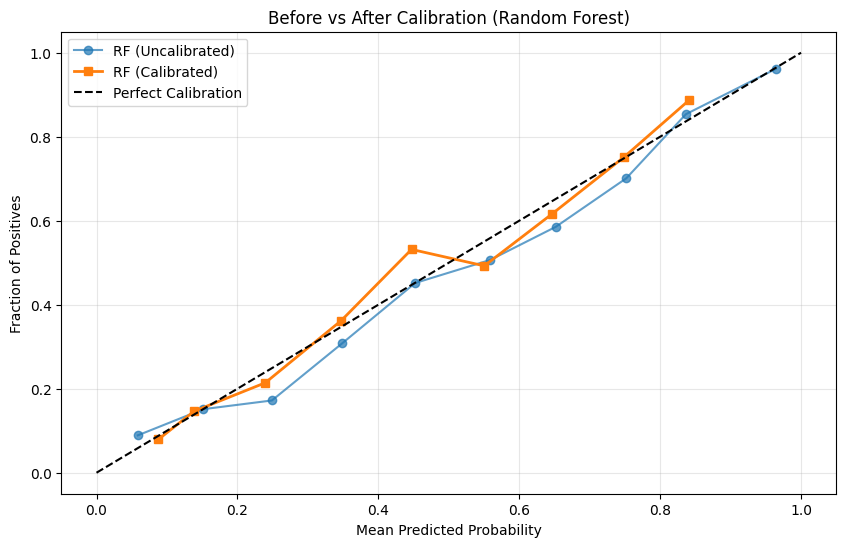


Calibrated RF Brier Score: 0.1392 (Original: 0.1405)
Improvement: 0.9%


In [5]:
# Calibrate Random Forest using Platt Scaling (Sigmoid)
rf_calibrated = CalibratedClassifierCV(rf, method='sigmoid', cv='prefit')
rf_calibrated.fit(X_test, y_test)  # Calibrate on test set (ideally use separate calibration set)
rf_calibrated_proba = rf_calibrated.predict_proba(X_test)[:, 1]

# Re-evaluate
prob_true_rf_cal, prob_pred_rf_cal = calibration_curve(y_test, rf_calibrated_proba, n_bins=10)

plt.figure(figsize=(10, 6))
plt.plot(prob_pred_rf, prob_true_rf, marker='o', label='RF (Uncalibrated)', alpha=0.7)
plt.plot(prob_pred_rf_cal, prob_true_rf_cal, marker='s', label='RF (Calibrated)', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Before vs After Calibration (Random Forest)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

rf_cal_brier = brier_score_loss(y_test, rf_calibrated_proba)
print(f"\nCalibrated RF Brier Score: {rf_cal_brier:.4f} (Original: {rf_brier:.4f})")
print(f"Improvement: {((rf_brier - rf_cal_brier) / rf_brier * 100):.1f}%")

## 5. Business Impact of Calibration

Why calibration matters for decision-making.

In [6]:
print("\n🎯 Business Application:")
print("\nIf we offer a retention discount to customers with >30% default risk:")
print("  - UNCALIBRATED: We might target the wrong 30% (overconfident predictions)")
print("  - CALIBRATED: We can trust that ~30% of targeted customers will actually default")
print("\nThis directly impacts campaign ROI and budget allocation.")


🎯 Business Application:

If we offer a retention discount to customers with >30% default risk:
  - UNCALIBRATED: We might target the wrong 30% (overconfident predictions)
  - CALIBRATED: We can trust that ~30% of targeted customers will actually default

This directly impacts campaign ROI and budget allocation.
